In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost
from xgboost import plot_importance
import math

In [395]:
data = pd.read_csv('dataset.csv', index_col = 0)

In [396]:
cont_var = ['host_listings_count','accommodates','bathrooms','bedrooms',
           'cleaning_fee','price','guests_included','extra_people','minimum_nights','number_of_reviews',
           'review_scores_rating','review_scores_cleanliness','review_scores_location','review_scores_value','calculated_host_listings_count',
           'reviews_per_month','amenities']

cat_var = ['host_response_time','host_acceptance_rate','host_has_profile_pic',
          'neighbourhood_cleansed','property_type','room_type',
          'bed_type','cancellation_policy','require_guest_profile_picture',
         'require_guest_phone_verification']



In [397]:
data = data[cont_var + cat_var]

In [398]:
drop_cols = ['review_scores_cleanliness','review_scores_location','review_scores_value','calculated_host_listings_count',
           'reviews_per_month', 'require_guest_profile_picture','require_guest_phone_verification','bed_type','host_has_profile_pic',
            ]

df = data.drop(drop_cols,1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 18 columns):
host_listings_count       3818 non-null float64
accommodates              3818 non-null float64
bathrooms                 3818 non-null float64
bedrooms                  3818 non-null float64
cleaning_fee              3818 non-null float64
price                     3818 non-null float64
guests_included           3818 non-null float64
extra_people              3818 non-null float64
minimum_nights            3818 non-null float64
number_of_reviews         3818 non-null float64
review_scores_rating      3818 non-null float64
amenities                 3818 non-null float64
host_response_time        3818 non-null int64
host_acceptance_rate      3818 non-null int64
neighbourhood_cleansed    3818 non-null int64
property_type             3818 non-null int64
room_type                 3818 non-null int64
cancellation_policy       3818 non-null int64
dtypes: float64(12), int64(6)
memory usag

In [399]:
df.isnull().sum()

host_listings_count       0
accommodates              0
bathrooms                 0
bedrooms                  0
cleaning_fee              0
price                     0
guests_included           0
extra_people              0
minimum_nights            0
number_of_reviews         0
review_scores_rating      0
amenities                 0
host_response_time        0
host_acceptance_rate      0
neighbourhood_cleansed    0
property_type             0
room_type                 0
cancellation_policy       0
dtype: int64

In [401]:
y = df['price']
X = df.drop('price',1)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = .33, random_state = 91)

In [402]:
linearRegressor = LinearRegression()
linearRegressor.fit(xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [403]:
for idx, col_name in enumerate(xtrain.columns):
    print("The coefficient for {} is {}".format(col_name, linearRegressor.coef_[idx]))


The coefficient for host_listings_count is 0.0575296547749
The coefficient for accommodates is 7.12673251299
The coefficient for bathrooms is 26.2139320366
The coefficient for bedrooms is 22.5388753561
The coefficient for cleaning_fee is 0.446008594686
The coefficient for guests_included is 4.05218737452
The coefficient for extra_people is 0.162615500949
The coefficient for minimum_nights is -0.994681779616
The coefficient for number_of_reviews is -0.03949493196
The coefficient for review_scores_rating is 0.775160812743
The coefficient for amenities is -0.00236531422446
The coefficient for host_response_time is -2.40574877517
The coefficient for host_acceptance_rate is -11.8701216984
The coefficient for neighbourhood_cleansed is 0.00332667726163
The coefficient for property_type is -1.21419810928
The coefficient for room_type is -31.6863364673
The coefficient for cancellation_policy is 3.59642575742


In [404]:
linearRegressor.score(xtest, ytest)

0.5702292461333938

In [405]:
ypredict = linearRegressor.predict(xtest)

regression_model_mse = mean_squared_error(ypredict, ytest)

regression_model_mse

3378.7707066946787

In [406]:
ridge = Ridge()
parameters = {'alpha':[15,5]}
ridge_reg = GridSearchCV(ridge,parameters,scoring = 'neg_mean_squared_error', cv = 5)
ridge_reg.fit(xtrain,ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1, param_grid={'alpha': [15, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [407]:
print(ridge_reg.best_params_)
print(ridge_reg.best_score_)

{'alpha': 15}
-3357.6556671254643


In [408]:
lasso = Lasso()
parameters = {'alpha':[.29,.293]}
lasso_reg = GridSearchCV(lasso,parameters,scoring = 'neg_mean_squared_error', cv = 5)
lasso_reg.fit(xtrain,ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.29, 0.293]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [409]:
print(lasso_reg.best_params_)
print(lasso_reg.best_score_)

{'alpha': 0.29}
-3358.908727157684


In [434]:
rf_regressor = RandomForestRegressor(random_state=42)
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
parameters = {'n_estimators':[10, 50, 100], 
              'min_samples_leaf':[1, 2, 3], 
              'max_depth':[2,5,10]}
scorer = 'neg_mean_squared_error'
n_iter_search = 10
grid_obj = RandomizedSearchCV(rf_regressor, 
                              parameters, 
                              n_iter = n_iter_search, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 99,n_jobs = -1)
grid_fit = grid_obj.fit(xtrain, ytrain)
rf_opt = grid_fit.best_estimator_

In [435]:
rf_opt

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [436]:
y_pred = pd.DataFrame(rf_opt.predict(xtest))

In [437]:
mean_squared_error(y_pred, ytest)

3153.6135290353086

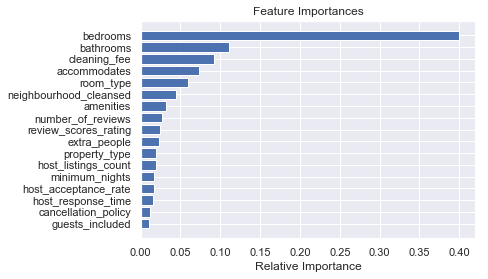

In [438]:
features = X.columns.tolist()
importances = rf_opt.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [439]:
def summary_plots(y_test, y_pred):
    fig, axes = plt.subplots(2,2,figsize = (10,10))
    fontsize = 15
    sns.distplot(y_pred, kde = False, ax = axes[0,0])
    axes[0,0].set_title('Histogram of Predicted Price', fontsize = fontsize)
    axes[0,0].set_xlabel('Predicted Price', fontsize = fontsize)
    axes[0,0].set_ylabel('Count', fontsize = fontsize)

    sns.regplot(y_test, y_pred, fit_reg = False, ax = axes[0,1])
    axes[0,1].set_title('Actual Price vs. Predicted Price', fontsize = fontsize)
    axes[0,1].set_xlabel('Actual Price', fontsize = fontsize)
    axes[0,1].set_ylabel('Predicted Price', fontsize = fontsize)
    
    sns.regplot(y_pred, y_test - y_pred, fit_reg = False, ax = axes[1,0])
    axes[1,0].set_title('Residual Plot', fontsize = fontsize)
    axes[1,0].set_xlabel('Predicted Price', fontsize = fontsize)
    axes[1,0].set_ylabel('Residuals', fontsize = fontsize)
    
    sns.distplot(y_test - y_pred, kde = False, ax = axes[1,1])
    axes[1,1].set_title('Histogram of Residuals', fontsize = fontsize)
    axes[1,1].set_xlabel('Residuals', fontsize = fontsize)
    axes[1,1].set_ylabel('Count', fontsize = fontsize)
        
    fig.tight_layout()    
    plt.show()

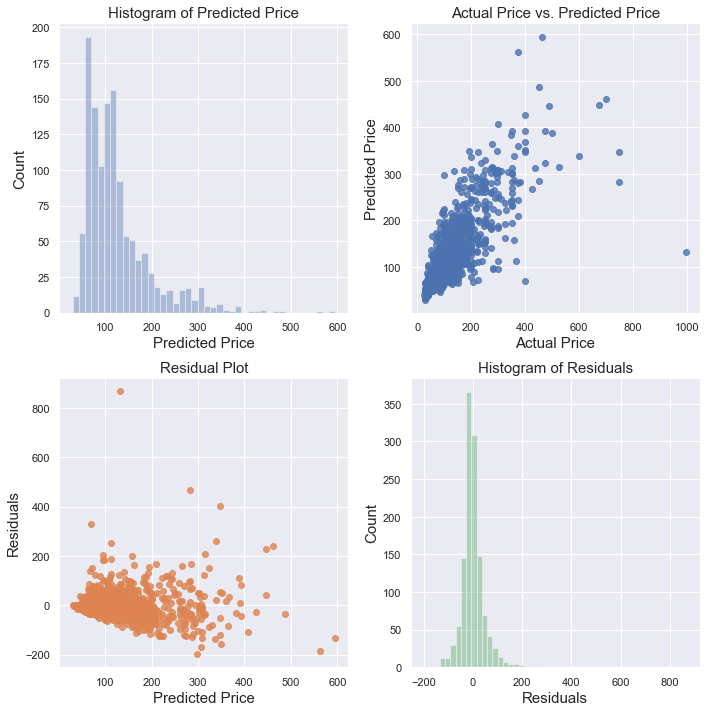

In [440]:
summary_plots(pd.DataFrame(ytest).values, y_pred.values)

In [482]:

xg_regressor = xgboost.XGBRegressor(random_state=42)
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
parameters = {'n_estimators':[10, 50, 100], 
              'min_child_weight':[1, 2, 3,5], 
              'max_depth':[2,5],
              'subsample': [.6,.9],
              'learning_rate': [.1,.2]}
scorer = 'neg_mean_squared_error'
n_iter_search = 10
grid_obj = RandomizedSearchCV(xg_regressor, 
                              parameters, 
                              n_iter = n_iter_search, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 99,n_jobs = -1)
grid_fit = grid_obj.fit(xtrain, ytrain)
xg_opt = grid_fit.best_estimator_
 

In [483]:
y_pred = pd.DataFrame(xg_opt.predict(xtest))
mean_squared_error(y_pred, ytest)

3116.5554975055784

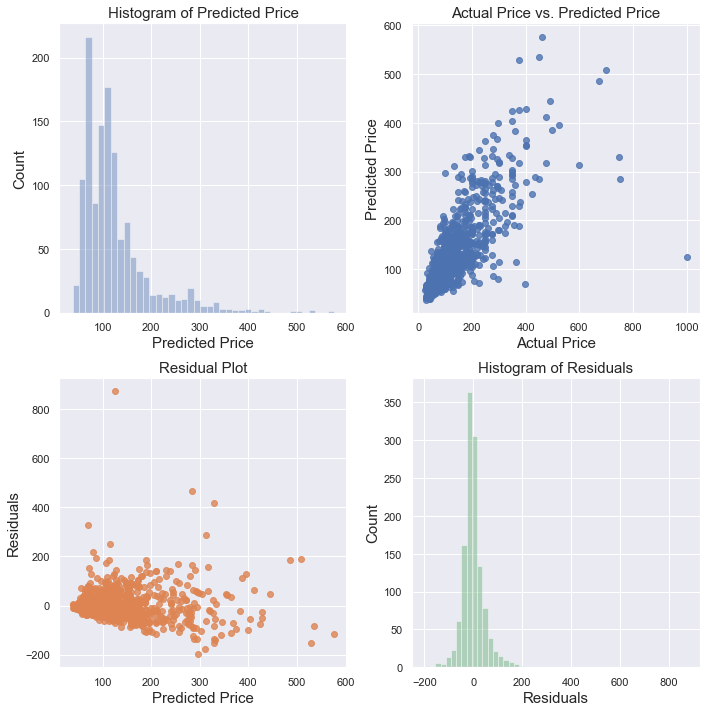

In [484]:
summary_plots(pd.DataFrame(ytest).values, y_pred.values)

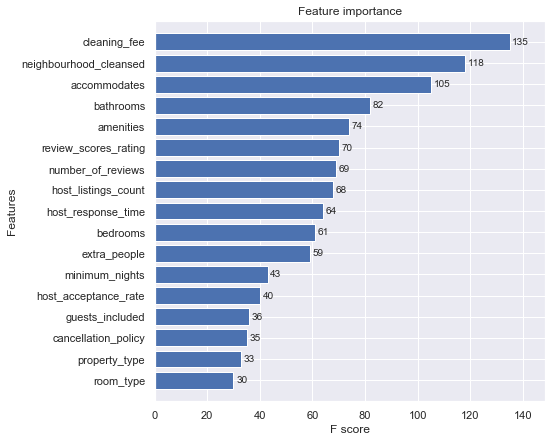

In [492]:
fig, ax = plt.subplots(figsize=(7,7))
xgboost.plot_importance(xg_opt, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Conclusions:
- I tried linear regression, lasso regression , ridge regression , Random Forest and xgboost algorithms
- xgboost gave the best prediction for the test set
- features like number of cleaning fee,neighborhood, accomodates, bathrooms,amenities and review scores plays a crucial roll in determining the price of the airbnb property.
- from the above plots we see that model is not able to predict high prices correctly. Collecting more data espicially for cases where the price > 400 may help in improving the model.

## Future Work:
-  I would like to generalize this model to other locations in the west Coast such as California, Oregon etc.